In [923]:
%matplotlib inline

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math
import pytesseract
import re

from functools import partial

In [897]:
%run four_point_transform.py

In [898]:
GREEN = (0, 255, 0)

In [899]:
def draw(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    
def apply_gray(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def apply_tophat(img, size=(9, 9)):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.morphologyEx(img, cv.MORPH_TOPHAT, kernel)

def apply_open(img, size=(9, 9)):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

def apply_close(img, size=(9, 9)):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

def apply_adaptive_threshold(img):
    thresh = cv.adaptiveThreshold(img, 255, 
                                  cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  thresholdType=cv.THRESH_BINARY_INV,
                                  blockSize=9,
                                  C=5)
    return thresh

def apply_otsu_threshold(img):
    thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY|cv.THRESH_OTSU)[1]
    return thresh

def apply_inverse(img):
    return cv.bitwise_not(img)

def find_edges(img):
    return cv.Canny(thresh, 50, 200, None, 3)

def apply_dilate(img, size=(5, 5), kernel=None):
    if kernel is None:
        kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.dilate(img, kernel)

def apply_erode(img, size=(5, 5), kernel=None):
    if kernel is None:
        kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.erode(img, kernel)

# nonzeros = cv.findNonZero(thresh)

def min_area_rect(contour):
    rect = cv.minAreaRect(contour)
    box = cv.boxPoints(rect)
    cnt = np.int0(box)
    return cnt

# vis = cv.drawContours(img.copy(), [cnt], -1, (0, 255, 0), 1)
# draw(vis)

def find_outer_boundary(thresh):
    cnts, _ = cv.findContours(thresh,
                              cv.RETR_LIST,
                              cv.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, 
                  key=cv.contourArea, 
                  reverse=True)
    cnt = None
    for c in cnts:
        # Approximate the contour.
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            cnt = approx
            break
    return cnt

def draw_contour(img, cnts, color=GREEN):
    draw(cv.drawContours(img, cnts, -1, color, 1))
    
def sobelxy(img, ksize=5):
    sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize)  # x
    sobely = cv.Sobel(sobelx, cv.CV_64F, 0, 1, ksize)  # y
    return sobely


def apply_horizontal_vertical_line_removal(img):
    minLineLength = img.shape[1] * 0.2
    maxLineGap = 10
    lines = cv.HoughLinesP(img, 1, np.pi/180, 100, minLineLength, maxLineGap)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv.line(img, (x1,y1), (x2,y2), (0,0,0), 3)
    return img

def apply_laplacian(img):
    laplacian = cv.Laplacian(img, cv.CV_8UC1) # Laplacian Edge Detection
    return laplacian


In [942]:
def match_int(s):
    match = re.match('\d+', s)
    if match is None:
        return -1
    return int(match.group(0))

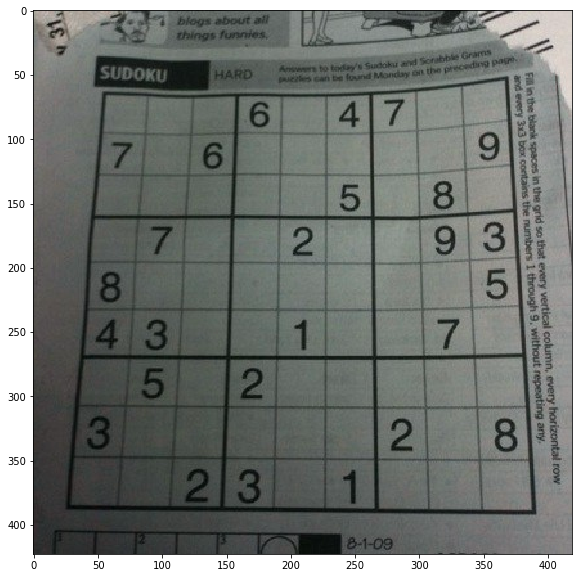

In [900]:
img = cv.imread('sudoku.jpeg')

draw(img)

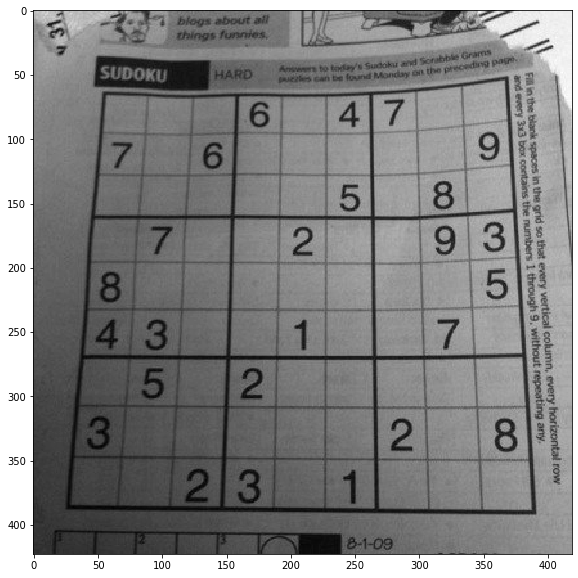

In [901]:
gray = apply_gray(img)
draw(gray)

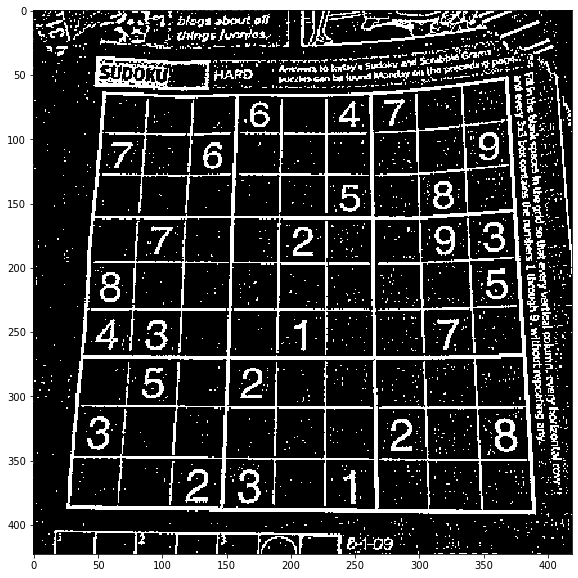

In [902]:
thresh = apply_adaptive_threshold(gray)
draw(thresh)

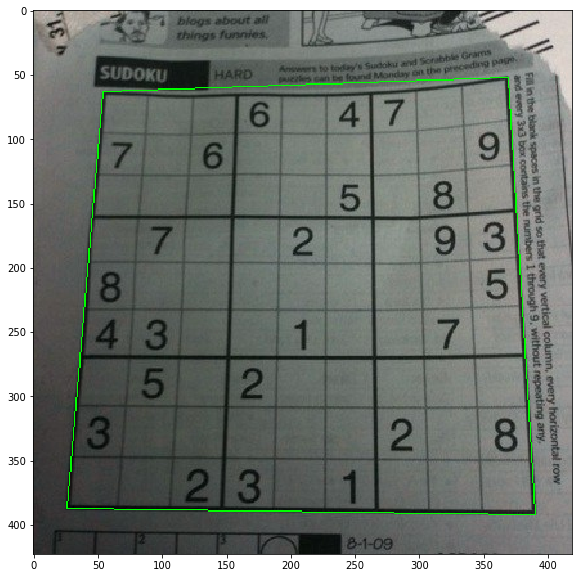

In [903]:
box = find_outer_boundary(thresh)
draw_contour(img, [box])

[[ 54.  63.]
 [369.  52.]
 [390. 392.]
 [ 26. 387.]]


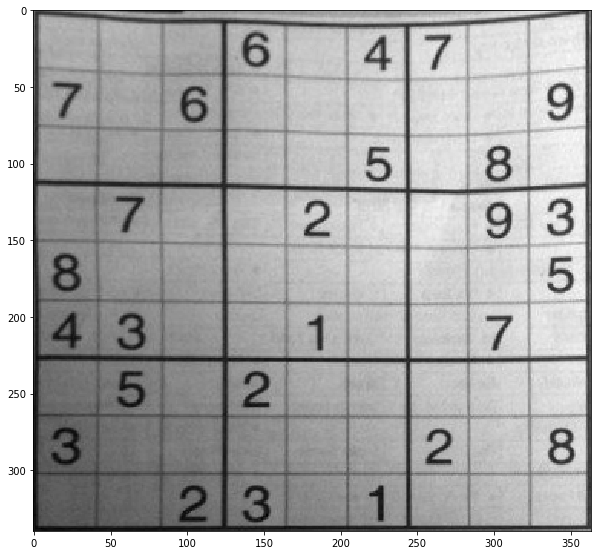

In [990]:
transform = four_point_transform(gray, box.reshape(4, 2))
draw(transform)

In [993]:
# print(pytesseract.image_to_string(transform, config='--psm 6'))

ieee! 14/7
SEGRE
a7 | | [9/3
ae. | {5
eel | 17
| |
|
al. |. |


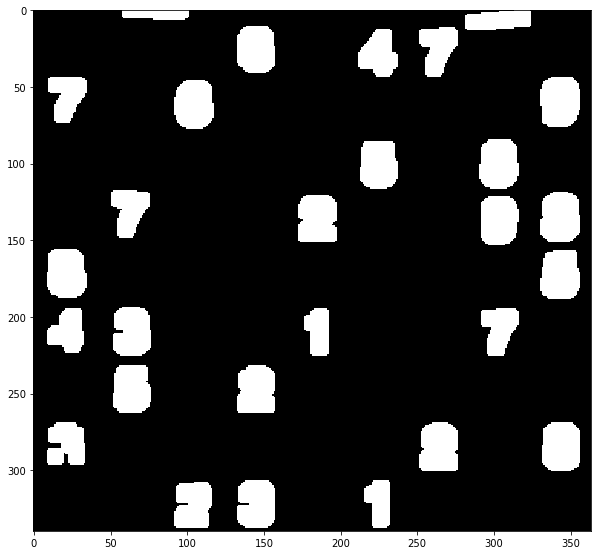

In [905]:
transformations = [
    apply_inverse,
    apply_tophat,
    apply_otsu_threshold,
    partial(apply_close, size=(3, 3)),
    apply_horizontal_vertical_line_removal,
    partial(apply_open, size=(3, 3)),
    apply_laplacian,
    partial(apply_dilate, size=(7, 7)),
]
dst = transform
for t in transformations:
    dst = t(dst)
draw(dst)

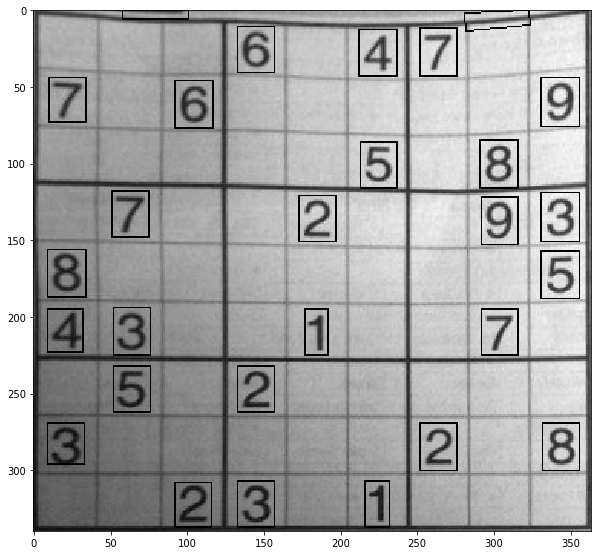

In [906]:
cnts, _ = cv.findContours(dst, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
grid = [min_area_rect(c) for c in cnts]

draw_contour(transform.copy(), grid)

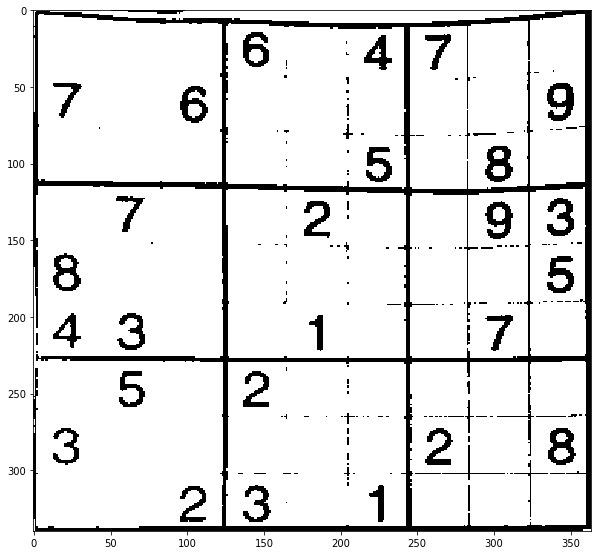

In [921]:
# Prepare target image to scan for text.
transformations = [
    apply_inverse,
    apply_tophat,
    apply_otsu_threshold,
    apply_inverse
]
tgt = transform
for t in transformations:
    tgt = t(tgt)
draw(tgt)

In [989]:
# Remove border.
rois = []
height, width = tgt.shape[:2]
sudoku = np.zeros((9, 9), np.int)

for c in cnts:
    x, y, w, h = cv.boundingRect(c)
    # The region of interest.
    roi = tgt[y:y+h, x:x+w]
    
    # Set edges to white.
    roi[:, 0] = 255
    roi[:, -1] = 255
    roi[0, :] = 255
    roi[-1, :] = 255
    rois.append(roi)
    
    text = pytesseract.image_to_string(roi, config='--psm 6') # Needs to be enabled to read single digit.
    out = match_int(text)
    if out == -1: continue

    mid_x = x + (w / 2)
    mid_y = y + (h / 2)
    i, j = int(mid_y/height * 9), int(mid_x/width * 9)
    sudoku[i, j] = out

In [994]:
sudoku

array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 8, 0],
       [0, 7, 0, 0, 2, 0, 0, 9, 3],
       [8, 0, 0, 0, 0, 0, 0, 0, 5],
       [4, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 2, 0, 8],
       [0, 0, 2, 3, 0, 1, 0, 0, 0]])

In [908]:
# vis = transform.copy()

# # rho in pixels.
# rho = 1

# # theta in degree.
# theta = np.pi/180

# # The minimum number of intersections to detect a line.
# threshold = 200

# lines = cv.HoughLines(edges, rho, theta, threshold, None, 0, 0)
# if lines is not None:
#     for rho, theta in lines[:,0]:
#         a = math.cos(theta)
#         b = math.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        
#         cv.line(vis, pt1, pt2, (0, 255, 0), 2, cv.LINE_AA)

# draw(vis)